# Working with the Kinodata-3D dataset

If you plan to use Kinodata-3D within any projects that involve geometric deep learning based on [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) you can re-use [our PyG dataset](#pyg-dataset).

For all other cases, we provide a [framework-agnostic dataset](#framework-agnostic-dataset).

## Framework-agnostic dataset

In [1]:
from kinodata.data import KinodataDockedAgnostic
from kinodata.data.data_module import make_data_module

dataset = KinodataDockedAgnostic()

/Users/joschka/mambaforge/envs/kinodata/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading raw data from /Users/joschka/projects/kinodata-docked-rescore/data/raw...
Reading data frame from /Users/joschka/projects/kinodata-docked-rescore/data/raw/kinodata_docked_with_rmsd.sdf.gz...
Deduping data frame (current size: 124761)...
122747 complexes remain after deduplication.
Checking for missing pocket mol2 files...


100%|██████████| 2885/2885 [00:00<00:00, 59948.91it/s]


Adding pocket sequences from cached file /Users/joschka/projects/kinodata-docked-rescore/data/raw/pocket_sequences.csv.
Converting to data list...
Done!


In [2]:
next(iter(dataset))

ComplexInformation(kinodata_ident='32336', compound_smiles='Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1', molecule=<rdkit.Chem.rdchem.Mol object at 0x14fc9a730>, activity_value=5.468521, activity_type='pIC50', pocket_mol2_file=PosixPath('/Users/joschka/projects/kinodata-docked-rescore/data/raw/mol2/pocket/5553_pocket.mol2'), docking_score=-10.307055, posit_probability=0.24, klifs_structure_id=5553, pocket_sequence='DVIGEG__GQVLKAAIKRM____ELEVLCKLGPNIINLLGAYLAIEYAPHGNLLDFLRKYLSQKQFIHRNLAARNILVIADFGLS', predicted_rmsd=4.790116, remove_hydrogen=True)

## PyG Dataset

In [3]:
from kinodata.data.dataset import KinodataDocked

### Create/load the dataset
Instantiating the dataset for the first time will trigger the data preprocessing, which creates the PyG data objects.
This process takes a while (~ 1 hour on a 2021 MacBook Pro), but the result is cached on disk to accelerate future instantiations.

**Note**: you may also obtain our [preprocessed version of the dataset](https://zenodo.org/records/10886085).

In [4]:
dataset = KinodataDocked()
dataset

KinodataDocked(104836)

### Data representation and data loading
Docked complexes are stored/represented as [heterogenous graph data](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.HeteroData.html?highlight=heterodata) objects.

In [5]:
data = dataset[42]
print(data)

HeteroData(
  kissim_fp=[1, 85, 12],
  y=[1],
  docking_score=[1],
  posit_prob=[1],
  predicted_rmsd=[1],
  pocket_sequence='KSLGRGAFGKVVQVAVKMLALMTELKILTHIGLNVVNLLGAMVIVEYCKYGNLSNYLKSFLSSRKCIHRDLAARNILLICDFGLA',
  scaffold='C1CCC(CC2CCCC2)CC1',
  activity_type='pIC50',
  ident='53974',
  smiles='Cc1cnc(Nc2ccccn2)s1',
  ligand={
    z=[13],
    x=[13, 12],
    pos=[13, 3]
  },
  pocket={
    z=[652],
    x=[652, 12],
    pos=[652, 3]
  },
  pocket_residue={ x=[85, 23] },
  (ligand, bond, ligand)={
    edge_index=[2, 28],
    edge_attr=[28, 4]
  },
  (pocket, bond, pocket)={
    edge_index=[2, 1306],
    edge_attr=[1306, 4]
  }
)


In [6]:
node_types, edge_types = data.metadata()
print(f"Node types: {', '.join([nt for nt in node_types])}")
print(f"Edge types: {', '.join([str(et) for et in edge_types])}")
print(f"Number of ligand heavy atoms: {data['ligand'].x.size(0)}")
print(f"Number of pocket heavy atoms: {data['pocket'].x.size(0)}")
print(f"Position of ligand atom indexed 0: {data['ligand'].pos[0]}")
print(f"Position of pocket atom indexed 0: {data['pocket'].pos[0]}")

Node types: ligand, pocket, pocket_residue
Edge types: ('ligand', 'bond', 'ligand'), ('pocket', 'bond', 'pocket')
Number of ligand heavy atoms: 13
Number of pocket heavy atoms: 652
Position of ligand atom indexed 0: tensor([ 1.3422, 21.6702, 38.2683])
Position of pocket atom indexed 0: tensor([ 9.7198, 18.2420, 49.8679])


Typically you'll want split data into train, test (and validation) sets.
You can choose to reuse our code for creating a data module that hosts datasets and loaders for train, test and validation splits.
This is detailed in [examples/data_splits.ipynb](data_splits.ipynb).

### Complex graph representation

In [7]:
import kinodata.transform as T

If you want to use the complex graph representation from the Kinodata-3D publication use

In [8]:
dataset = KinodataDocked(
    transform=T.TransformToComplexGraph(remove_heterogeneous_representation=True)
)

In [9]:
data = dataset[42]

node_types, edge_types = data.metadata()
print(f"Node types: {', '.join([nt for nt in node_types])}")
print(f"Edge types: {', '.join([str(et) for et in edge_types])}")
print(f"Number of complex heavy atoms: {data['complex'].x.size(0)}")

Node types: pocket_residue, complex
Edge types: ('complex', 'bond', 'complex')
Number of complex heavy atoms: 665


When creating a data module, holding different (i.e. train, validation, and test) datasets, the transform is passed down to the datasets via the `train_kwargs`, `val_kwargs` and `test_kwargs` keyword arguments;

In [10]:
# this could take a while, expect ~60 seconds
from kinodata.data.grouped_split import KinodataKFoldSplit

demo_split = KinodataKFoldSplit("random-k-fold", k=5).split(dataset)[0]
data_module = make_data_module(
    split=demo_split,
   batch_size=32,
   dataset_cls=KinodataDocked,
   num_workers=0,
   train_kwargs=dict(
       transform=T.TransformToComplexGraph(),
   ),
)

In [11]:
demo_batch = next(iter(data_module.train_dataloader()))
demo_batch

HeteroDataBatch(
  kissim_fp=[32, 85, 12],
  y=[32],
  docking_score=[32],
  posit_prob=[32],
  predicted_rmsd=[32],
  pocket_sequence=[32],
  scaffold=[32],
  activity_type=[32],
  ident=[32],
  smiles=[32],
  ligand={
    z=[931],
    x=[931, 12],
    pos=[931, 3],
    batch=[931],
    ptr=[33]
  },
  pocket={
    z=[21094],
    x=[21094, 12],
    pos=[21094, 3],
    batch=[21094],
    ptr=[33]
  },
  pocket_residue={
    x=[2720, 23],
    batch=[2720],
    ptr=[33]
  },
  complex={
    x=[22025, 12],
    z=[22025],
    pos=[22025, 3],
    batch=[22025],
    ptr=[33]
  },
  (ligand, bond, ligand)={
    edge_index=[2, 2066],
    edge_attr=[2066, 4]
  },
  (pocket, bond, pocket)={
    edge_index=[2, 42460],
    edge_attr=[42460, 4]
  },
  (complex, bond, complex)={
    edge_index=[2, 44526],
    edge_attr=[44526, 4]
  }
)

### Relative structural information

Note that the structural information is encoded as absolute 3D coordinates in the above data sets.

Our transformer adds distance-based edges on the fly, which is implemented in a separated PyTorch `nn.Module`.

In [12]:
from kinodata.model.complex_transformer import StructuralInteractions

In [13]:
interaction_module = StructuralInteractions(
    32,
    interaction_radius=5.0,
    max_num_neighbors=16,
    rbf_size=32
)

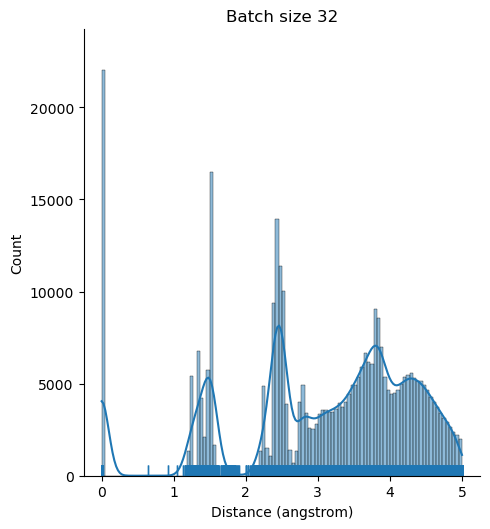

In [14]:
import seaborn as sns
edge_index, _, distances = interaction_module.interactions(demo_batch)

fig = sns.displot(x=distances.numpy(), kde=True, rug=True)
fig.axes[0,0].set_title(f"Batch size {demo_batch['ligand'].batch.max().item() + 1}")
_ = fig.axes[0,0].set_xlabel("Distance (angstrom)")